## **Installing required packages**

In [ ]:
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs

## **Import libraries**(*for Classical approach*)

In [2]:
import pandas as pd
import numpy as np
import os
import gensim
import itertools
import re

import matplotlib.pyplot as plt
import seaborn as sns 

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn import metrics
from sklearn.utils import shuffle

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")


import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Error loading english: Package 'english' not found in
[nltk_data]     index


False

In [3]:
# checking for available GPU
import torch
torch.cuda.is_available()

True

## **Downloading Data** : Data used is from the famous IMDB movie reviews dataset. We will use HuggingFace hub to download it.

In [4]:
from datasets import load_dataset
imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
imdb["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

### Splitting data and picking a suitable part for training and testing

Shuffling data before slicing to avoid biasing to some class as it may be originally saved in some ascending or descending order

In [6]:
df_train = (shuffle(pd.DataFrame(imdb["train"])).iloc[0:10000]).reset_index(drop=True)
df_test = shuffle(pd.DataFrame(imdb["test"])).iloc[0:800].reset_index(drop=True)

In [7]:
df_train

,text,label
0,just saw this exquisite 1982 movie Return of t...,1
1,Cuban Blood is one of those sleeper films that...,1
2,"Interesting, fast-paced and amusing.<br /><br ...",1
3,Since the start of her career in the 70's and ...,1
4,This movie truly captures the feeling of freed...,1
...,...,...
9995,This film was an interesting take by Hollywood...,1
9996,This documentary was very thorough and exposin...,1
9997,This could have been a rather entertaining fil...,0
9998,This may not be one of the best movies ever ma...,1


### simple EDA

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [9]:
df_train['label'].value_counts()

1    5069
0    4931
Name: label, dtype: int64

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    800 non-null    object
 1   label   800 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.6+ KB


In [11]:
df_test['label'].value_counts()

0    407
1    393
Name: label, dtype: int64

In [12]:
print(df_train['text'][5])

Having just watched this film again from a 1998 showing off VH-1, I just had to comment.<br /><br />The first time I saw this film on TV, it was about 1981, and I remember taping it off of my mother's betamax. It wound up taping in black and white for some reason, which gave it a period look that I grew to like.<br /><br />I remember very distinctively the film beginning with the song, "My Bonnie", as the camera panned over a scene of Liverpool. I also remember the opening scene where Paul gestures to some girls and says, "Look, talent!" So it was with great irritation that I popped in my 1998 taped version and "remembered" that the film opens with "She Loves You", instead of "My Bonnie". When you see how slowly the camera pans vs. the speed of the music, you can see that "She Loves You" just doesn't fit. Also, in this "later" version when Paul sees the girls, he says, "Look, GIRLS!"..and somehow having remembered the earlier version, THAT word just didn't seem to fit, either. Why they

### Simple preprocessing for feature extraction and preparing data fo the model

This code performs preprocessing on movie review text data in df_train. It initializes a Porter Stemmer object, removes non-alphabetic characters, converts the text to lowercase, splits it into words, applies stemming to each word, and removes stopwords. The preprocessed text is added to a corpus list, which can be used for training a machine learning or deep learning model.

In [13]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(df_train)):
    review = re.sub('[^a-zA-Z]', ' ', df_train['text'][i])
    review = review.lower()
    review = review.split()  
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [14]:
corpus[6]

'obvious lot talent behind scene crew member work movi even look credit end hold nobodi seem interest see movi theater two pass minut lucki one monster unemploy worm star trek wrath khan reject design space creatur alien creator movi obvious want overshadow third rate movi monster hire forth rate actor appar get memor line case learn pronounc word film began scene incred inept convey suppos happen anyth unfortun enough theater movi show pass laugh suppos frighten suspens moment film implaus sever scene stun stephen dorff regular spew queen mari curs word convey feel anyon pay see must see movi favor wait bargain bin video store justic film industri one main actor rent'

And same for testing data

In [15]:
corpus_test = []
for i in range(0, len(df_test)):
    review = re.sub('[^a-zA-Z]', ' ', df_test['text'][i])
    review = review.lower()
    review = review.split()  
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_test.append(review)

In [16]:
countvector=CountVectorizer(max_features=500,ngram_range=(1,3))
X_train = countvector.fit_transform(corpus).toarray()
X_test = countvector.transform(corpus_test).toarray()

In [17]:
X_test

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 2, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [18]:
y_train,y_test = df_train['label'].values,df_test['label'].values

### Using Multinomial NB classifier as a good practice in such problem

Multinomial Naive Bayes is a probabilistic algorithm that uses Bayes' theorem to predict the probability of a given class label based on the frequency of features in the training data. It is used in sentiment analysis because it works well with text data and can handle a large number of features efficiently.

In [19]:
classifier= MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In [20]:
y_pred = classifier.predict(X_test)

### Evaluation metrics

Here we use several classification metrics such as classification report accuracy score and the more importantly the confusion matrix

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       407
           1       0.80      0.83      0.82       393

    accuracy                           0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.82      0.82       800

******************************************************************************************************************************************************

Accuracy score is  0.81625 

******************************************************************************************************************************************************



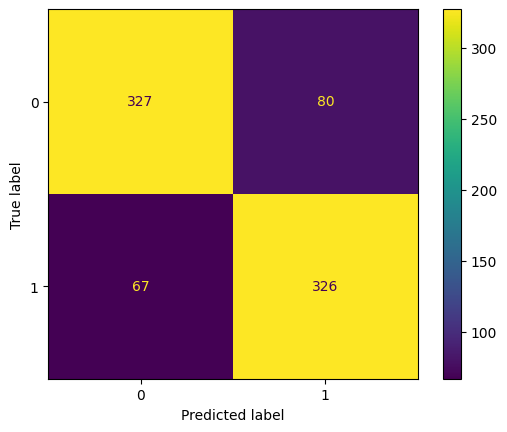

In [21]:
print(classification_report(y_test, y_pred))
print(150 * '*'+'\n')
score=accuracy_score(y_test,y_pred)
print("Accuracy score is " , score ,'\n')
print(150 * '*'+'\n')
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(cm,display_labels=classifier.classes_)
disp.plot()
plt.show();

In [22]:
ex =["The bear was so happy that he shed a tear", "I can't bear this awful movie anymore."]
corpus_ex=[]
for i in range(0, len(ex)):
    review = re.sub('[^a-zA-Z]', ' ', ex[i])
    review = review.lower()
    review = review.split()  
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_ex.append(review)

classifier.predict(countvector.transform(corpus_ex).toarray())
  

array([1, 0])

In [23]:
ex =["I love you ", "You are bad"]
corpus_ex=[]
for i in range(0, len(ex)):
    review = re.sub('[^a-zA-Z]', ' ', ex[i])
    review = review.lower()
    review = review.split()  
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_ex.append(review)

classifier.predict(countvector.transform(corpus_ex).toarray())
  

array([1, 0])

## As we can from previous analysis that Although ***Multinomial Naive Bayes Classifier*** is fast it is also not the most accurate classifier.
## We are going to use a ***Transformer-based Model*** with all of its revolutionary achievements to adress the same problem


---

## **The Deep learning approach**

In [24]:
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(10000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(800))])

Transformers are deep learning models that have revolutionized NLP by being able to capture the context of speech more accurately than previous models. They use a self-attention mechanism to weigh the importance of different words in a sentence and can handle variable-length inputs, making them ideal for tasks like sentiment analysis.

In [25]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

This code creates a preprocess_function that tokenizes text examples using a tokenizer with truncation parameter set to limit the length of text. The function is applied to datasets using the map() function, resulting in tokenized versions of the datasets ready for training a model.

In [26]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)
 
tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

The code instantiates an object of the DataCollatorWithPadding class from the transformers library and assigns it to the variable data_collator. This class is responsible for batching and padding tokenized inputs in a dataset, and it is initialized with a previously defined tokenizer object. The resulting data_collator instance can be used to create data loaders for training a machine learning or deep learning model.

In [27]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Calling a pretrained model 

In [28]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=2)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.w

loading required metrics such as f1 and accurancy

In [29]:
import numpy as np
from datasets import load_metric
 
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

Training and adjusting hyperparameters

In [30]:
from transformers import TrainingArguments, Trainer
 
 
training_args = TrainingArguments(
   output_dir="/content/output",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=5,
   weight_decay=2,
   save_strategy="epoch",
   push_to_hub=False
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


In [31]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.354100
1000,0.219900
1500,0.160200
2000,0.112000
2500,0.064100
3000,0.036900


TrainOutput(global_step=3125, training_loss=0.15292159423828125, metrics={'train_runtime': 2351.9168, 'train_samples_per_second': 21.259, 'train_steps_per_second': 1.329, 'total_flos': 6559814558688576.0, 'train_loss': 0.15292159423828125, 'epoch': 5.0})

In [32]:
trainer.evaluate()

{'eval_loss': 0.4455713629722595,
 'eval_accuracy': 0.91,
 'eval_f1': 0.9081632653061225,
 'eval_runtime': 14.2693,
 'eval_samples_per_second': 56.064,
 'eval_steps_per_second': 3.504,
 'epoch': 5.0}

Here are the improvements

### **Evaluation :**

In [44]:
y_pred_deep = trainer.predict(tokenized_test).predictions

In [45]:
y_pred_deep = np.argmax(y_pred_deep,axis=1)
y_true_deep= np.array([example['label'] for example in tokenized_test])

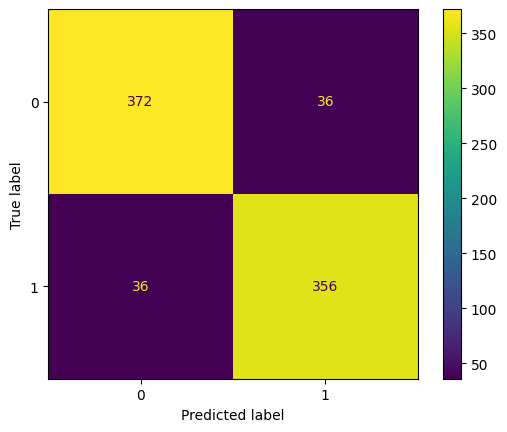

In [46]:
cm_deep  = confusion_matrix(y_true_deep, y_pred_deep)
disp_deep = ConfusionMatrixDisplay(cm_deep)
disp_deep.plot()
plt.show();

### *Here we can actually see the major difference in performance nearly reduces the confusion in examples to the half*

## Saving parameters of our fine-tuned model to use it further 

In [35]:
#save the model
trainer.save_model("/content/model")

## Trying it on examples

In [36]:
from transformers import pipeline
# Load the saved model 
model_path = "/content/model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Create a pipeline for text classification
sentiment_model = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer
)

# Use the pipeline to process new inputs
sentiment_model(["The bear was so happy that he shed a tear", "I can't bear this awful movie anymore."])

[{'label': 'LABEL_1', 'score': 0.988021731376648},
 {'label': 'LABEL_0', 'score': 0.9978892207145691}]

In [38]:
data_2 = [  "You are bad","I love you "]
sentiment_model(data_2)

[{'label': 'LABEL_0', 'score': 0.9242176413536072},
 {'label': 'LABEL_1', 'score': 0.9932164549827576}]